### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempPropSelection/'
base_path = '../results/propensity_selection/'

treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 253 ms, sys: 147 ms, total: 400 ms
Wall time: 791 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201710

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.6 s, sys: 42.5 ms, total: 13.7 s
Wall time: 13.7 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 93 columns]

In [12]:
survTr.shape, survCo.shape

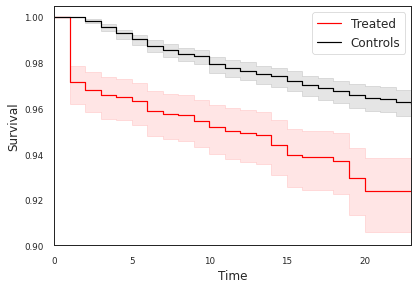

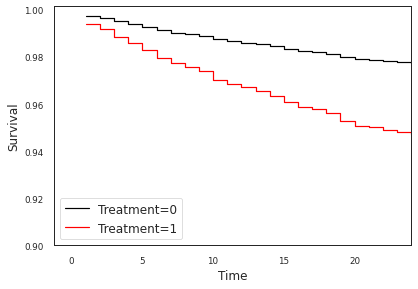

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       43.432257  4.388931e-11  34.407339

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               2.073           0.467        4.438    0.000
Total Cost                        0.056           0.024        2.292    0.022
Gender                            0.325           0.136        2.386    0.017
Tobacco Use                      -0.171           0.238       -0.718    0.473
Pressure                         -0.254           0.731       -0.347    0.728
Obesity                           0.454           0.131        3.476    0.001
Hypertension                     -0.021           0.144       -0.143    0.886
Hypothyroid                      -0.129           0.197       -0.658    0.511
Disease Count                     1.365           0.549        2.488    0.013
Acute Care 2 Months               1.133           0.338        3.356    0.001
Acute Care 6 Months              -1.798           0.701       -2.564    0.010
Inpatient Visits 6 Months         1.012           0.544        1.860    0.063
Emergency Vistits 6 Months        1.334           0.625        2.135    0.033
Line of Bussiness                -0.758           0.189       -4.016    0.000
Treatment                         0.866           0.125        6.946    0.000

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.7 s, sys: 58.9 ms, total: 13.8 s
Wall time: 13.8 s


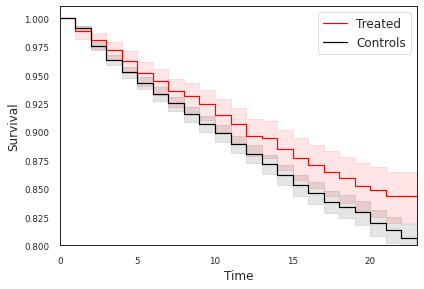

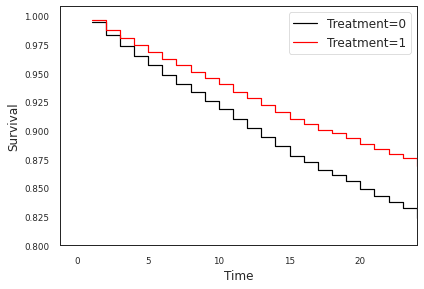

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.8]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        6.263069  0.012328  6.341912

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.050           0.216       -4.872    0.000
Total Cost                        0.031           0.012        2.650    0.008
Gender                           -0.158           0.076       -2.073    0.038
Tobacco Use                       0.080           0.103        0.781    0.435
Pressure                         -0.502           0.370       -1.357    0.175
Obesity                          -0.079           0.064       -1.244    0.214
Hypertension                      0.091           0.074        1.218    0.223
Hypothyroid                      -0.275           0.109       -2.521    0.012
Disease Count                     1.662           0.278        5.974    0.000
Acute Care 2 Months               1.317           0.137        9.619    0.000
Acute Care 6 Months              -0.324           0.310       -1.044    0.297
Inpatient Visits 6 Months        -0.108           0.245       -0.439    0.661
Emergency Vistits 6 Months        0.979           0.287        3.410    0.001
Line of Bussiness                -0.613           0.083       -7.390    0.000
Treatment                        -0.323           0.081       -4.002    0.000

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.6 s, sys: 26.5 ms, total: 13.6 s
Wall time: 13.6 s


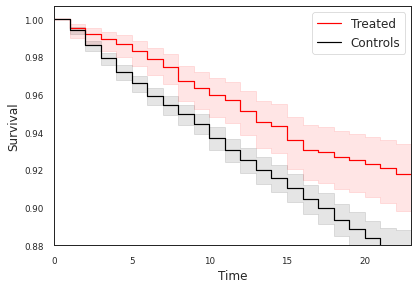

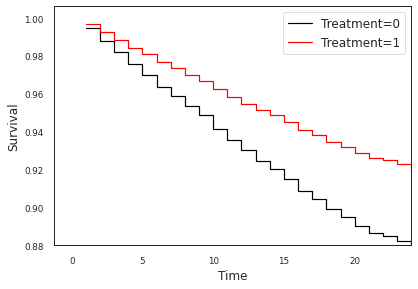

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.88]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [24]:
lrsumm

test_statistic         p   -log2(p)
Inpatient Visits       13.778965  0.000206  12.247692

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.387           0.269       -1.437    0.151
Total Cost                        0.109           0.016        6.800    0.000
Gender                           -0.306           0.103       -2.974    0.003
Tobacco Use                      -0.261           0.151       -1.726    0.084
Pressure                          0.165           0.341        0.485    0.628
Obesity                          -0.111           0.079       -1.400    0.162
Hypertension                      0.057           0.093        0.618    0.537
Hypothyroid                       0.079           0.115        0.688    0.492
Disease Count                     1.763           0.321        5.488    0.000
Acute Care 2 Months               1.054           0.165        6.395    0.000
Acute Care 6 Months              -0.738           0.290       -2.546    0.011
Inpatient Visits 6 Months         1.411           0.263        5.372    0.000
Emergency Vistits 6 Months        0.650           0.253        2.571    0.010
Line of Bussiness                -0.069           0.125       -0.552    0.581
Treatment                        -0.451           0.108       -4.195    0.000

### Acute Care IP OR ER

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.7 s, sys: 50.4 ms, total: 13.8 s
Wall time: 13.8 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
4     2619378   3  1      0     0.0     0.0        1               78   
5     2621187  11  1      0     0.0     0.0        2               78   
6     2623521  28  1      0     0.0     0.0        0               77   
16    2649799   8  1      0     0.0     0.0        1               74   
17    2651688   4  1      0     0.0     0.0        0               74   
...       ...  .. ..    ...     ...     ...      ...              ...   
1550  5003629  15  1      0     0.0     0.0        0               27   
1557  5010677  16  1      0     0.0     0.0        0               39   
1562  5014675   3  1      0     0.0     0.0        1               26   
1575  5021778   1  1      1     1.0     1.0        1               24   
1586  5028397   2  1      0     0.0     0.0        0               39   

      ALLOW_AMT  ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4           399       0.0  ...       0      0.0      0.0     0    1         1   
5         13007       0.0  ...       0      0.0      0.0     0    1         1   
6             0       0.0  ...       0      0.0      0.0     0    1         0   
16          333       0.0  ...       0      0.0      0.0     1    1         1   
17          179       0.0  ...       0      0.0      0.0     0    1         1   
...         ...       ...  ...     ...      ...      ...   ...  ...       ...   
1550          0       0.0  ...       0      0.0      0.0     0    1         0   
1557          0       0.0  ...       0      0.0      0.0     0    1         0   
1562        409       0.0  ...       0      0.0      0.0     0    1         0   
1575      20355    1161.0  ...       0      0.0      0.0     0    1         0   
1586          0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
17        Medicare  202011        0.0          1  
...            ...     ...        ...        ...  
1550    Commercial  201912        0.0          1  
1557    Commercial  202001        0.0          1  
1562    Commercial  202010        0.0          1  
1575    Commercial  202007        0.0          1  
1586    Commercial  202005        0.0          1  

[258 rows x 94 columns]

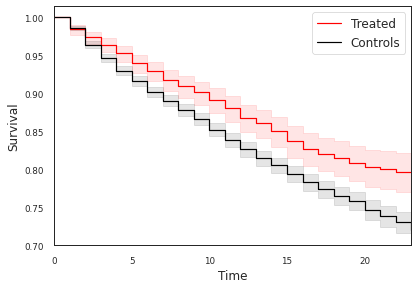

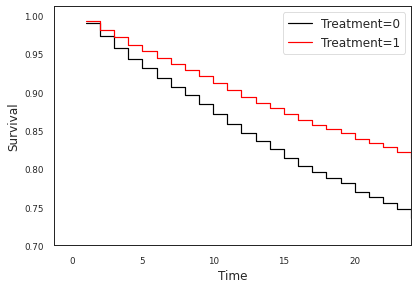

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [30]:
lrsumm

test_statistic         p   -log2(p)
Acute Care       17.358049  0.000031  14.979308

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.884           0.181       -4.894    0.000
Total Cost                        0.066           0.010        6.474    0.000
Gender                           -0.224           0.066       -3.410    0.001
Tobacco Use                       0.013           0.091        0.141    0.888
Pressure                          0.442           0.259        1.709    0.088
Obesity                          -0.094           0.053       -1.776    0.076
Hypertension                      0.065           0.063        1.032    0.302
Hypothyroid                      -0.078           0.086       -0.906    0.365
Disease Count                     1.434           0.235        6.112    0.000
Acute Care 2 Months               1.535           0.116       13.240    0.000
Acute Care 6 Months               0.007           0.258        0.027    0.978
Inpatient Visits 6 Months         0.201           0.229        0.878    0.380
Emergency Vistits 6 Months        0.413           0.238        1.730    0.084
Line of Bussiness                -0.458           0.074       -6.230    0.000
Treatment                        -0.397           0.069       -5.716    0.000

### Acute Care  diff and diff calculation

In [32]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 11.5 s, sys: 12.4 s, total: 24 s
Wall time: 24 s


In [33]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
for d in data2:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 32.4 s, sys: 3.72 s, total: 36.2 s
Wall time: 36.1 s


In [34]:
treated2.shape, controls2.shape

In [35]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [36]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [37]:
%%time
times = [0]
onset = 'Acute-bin'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.2 s, sys: 97.2 ms, total: 12.3 s
Wall time: 12.3 s


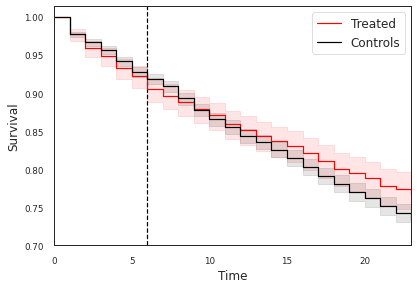

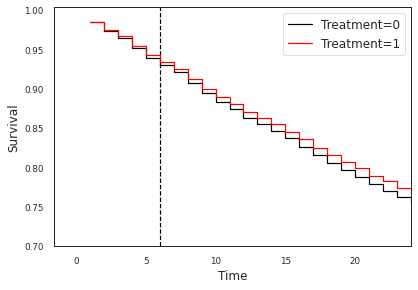

In [38]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [39]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd        4.637464  0.031281  4.998561

In [40]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.658           0.181       -3.641    0.000
Total Cost                        0.074           0.010        7.451    0.000
Gender                           -0.161           0.064       -2.537    0.011
Tobacco Use                      -0.064           0.093       -0.693    0.488
Pressure                          0.349           0.268        1.303    0.193
Obesity                          -0.091           0.052       -1.742    0.081
Hypertension                     -0.125           0.063       -1.983    0.047
Hypothyroid                      -0.091           0.081       -1.123    0.262
Disease Count                     1.731           0.227        7.614    0.000
Acute Care 2 Months               1.442           0.103       14.030    0.000
Acute Care 6 Months               0.336           0.218        1.541    0.123
Inpatient Visits 6 Months        -0.210           0.188       -1.115    0.265
Emergency Vistits 6 Months       -0.006           0.202       -0.032    0.974
Line of Bussiness                -0.505           0.073       -6.884    0.000
Treatment                        -0.059           0.063       -0.936    0.349

### Load all Log Rank Sums in a matrix

In [41]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [42]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      43.43                  0.00   
Emergency Visits               6.26                  0.01   
Inpatient Vistis              13.78                  0.00   
Acute Care                    17.36                  0.00   
Acute Care DD                  4.64                  0.03   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.14   
Emergency Visits                            0.03   
Inpatient Vistis                            0.05   
Acute Care                                  0.07   
Acute Care DD                              -0.03   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.31   
Emergency Visits                             0.12   
Inpatient Vistis                             0.17   
Acute Care                                   0.28   
Acute Care DD                               -0.05   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.49   
Emergency Visits                             0.26   
Inpatient Vistis                             0.33   
Acute Care                                   0.54   
Acute Care DD                                0.03   

                  RMST Difference After 24 Months  
Diabetes                                    -0.71  
Emergency Visits                             0.45  
Inpatient Vistis                             0.57  
Acute Care                                   0.90  
Acute Care DD                                0.19